#### 生成线性方程组的哈密顿量，并使用 VQE 求解得到基态及其基态能量，初始参数由最优参数随机扰动得来，生成两次迭代过程，一次是期望值模式，一次是测量模式

In [1]:
# 导入必要的库
import time
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from pennylane import numpy as qml_np

import VQE_until
import hamiltonian_until

##### 使用 VQE 进行求解

In [2]:
# 参数设置
steps = 200  # 迭代次数
eta = 0.4  # 学习率
seed = 1024 # 种子数
tol = 1e-4 # 终止条件
deep_layer = 1 # 电路层数


# 量子数
tol_qubits = hamiltonian_until.tol_qubits

# 优化器
# opt = qml.GradientDescentOptimizer(stepsize=0.1)
opt = qml.AdamOptimizer(stepsize=eta)

# 构造量子设备
# 第一个设备不需要测量
dev_ideal = qml.device("lightning.qubit", wires=tol_qubits, shots=None)
# 第二个设备采用测量模式，且测量次数为 1024 
shots = 1024
dev_sample = qml.device("lightning.qubit", wires=tol_qubits, shots=shots)

# 定义损失函数
cost_fn = VQE_until.variational_circuit_expval

# 创建运行节点
qnode_ideal = qml.QNode(cost_fn, dev_ideal)
qnode_sample = qml.QNode(cost_fn, dev_sample)

# 一层电路时的最优参数
params_old = qml_np.array([4.71237303, 4.7124589,  1.57078406, 4.71237222, 4.71235171, 1.5708085,
 1.57080377, 1.57074532, 1.57081405, 4.71238723, 1.57089928, 4.71242189])

# 在最优参数附近，添加扰动
qml_np.random.seed(seed)
error = qml_np.random.uniform(low=-0.5, high=0.5, size=(deep_layer * tol_qubits,))

params = params_old + error
print("error = ", error)
print("params = ", params)

error =  [ 0.14769123  0.49691358  0.01880326  0.15811273  0.09906347  0.25306733
 -0.36375287 -0.49588288 -0.35049112  0.198439    0.09335256  0.39991535]
params =  [4.86006426 5.20937248 1.58958732 4.87048495 4.81141518 1.82387583
 1.2070509  1.07486244 1.22032293 4.91082623 1.66425184 5.11233724]


In [3]:
# 非测量模式下，参数的迭代优化


# 存储损失值和参数
ideal_cost_history = []
ideal_params_history = [params]

for it in range(steps):
    
    start = time.time()
    
    params_lsit, cost = opt.step_and_cost(qnode_ideal, params, deep_layer)
    # print("params_lsit = ", params_lsit)
    # print("cost = ", cost)

    # 返回来的 list，包含参数和deep_layer等
    params = params_lsit[0]
    # 存储每一次更新后的参数及损失值
    ideal_params_history.append(params)
    ideal_cost_history.append(cost)
    
    end = time.time()
    
    if it % 2:
        print(f"Step = {it},  Energy = {ideal_cost_history[-1]:.8f}, Time = {end - start}")

    # 终止条件
    if len(ideal_cost_history) !=1 and abs(ideal_cost_history[-1] - ideal_cost_history[-2]) < tol:
        break    

# 上述存储过程，energy_list 比 params_list 少了最后一项       
ideal_cost_history.append(qnode_ideal(params, deep_layer))


print("\n" f"Final value of the ground-state energy = {ideal_cost_history[-1]:.8f}")
print("\n" f"Optimal value of the circuit parameter = {ideal_params_history[-1]}")

Step = 1,  Energy = 3452.79405105, Time = 1.2646679878234863
Step = 3,  Energy = 2317.84891013, Time = 1.1340150833129883
Step = 5,  Energy = 1376.06738675, Time = 1.1084709167480469
Step = 7,  Energy = 852.18515045, Time = 1.1673121452331543
Step = 9,  Energy = 1222.23595964, Time = 1.157456398010254
Step = 11,  Energy = 286.10828179, Time = 1.0945417881011963
Step = 13,  Energy = 583.56094982, Time = 1.1822607517242432
Step = 15,  Energy = 426.87527379, Time = 1.1683907508850098
Step = 17,  Energy = 170.28077714, Time = 1.104602575302124
Step = 19,  Energy = 199.64388698, Time = 1.1831550598144531
Step = 21,  Energy = 229.24734392, Time = 1.2209503650665283
Step = 23,  Energy = -51.41082131, Time = 1.1119999885559082
Step = 25,  Energy = 149.10264905, Time = 1.1954143047332764
Step = 27,  Energy = -29.20729906, Time = 1.1801917552947998
Step = 29,  Energy = -23.01939545, Time = 1.102339506149292
Step = 31,  Energy = -4.93947322, Time = 1.1905128955841064
Step = 33,  Energy = -79.4255

In [4]:
# 测量模式下，参数的迭代优化


# 存储损失值和参数
sample_cost_history = []
sample_params_history = [params]

for it in range(steps):
    
    start = time.time()
    
    params_lsit, cost = opt.step_and_cost(qnode_sample, params, deep_layer)

    # 返回来的 list，包含参数和deep_layer等
    params = params_lsit[0]
    # 存储每一次更新后的参数及损失值
    sample_params_history.append(params)
    sample_cost_history.append(cost)
    
    end = time.time()
    
    if it % 2:
        print(f"Step = {it},  Energy = {sample_cost_history[-1]:.8f}, Time = {end - start}")

    # 终止条件
    if len(sample_cost_history) !=1 and abs(sample_cost_history[-1] - sample_cost_history[-2]) < tol:
        break    

# 上述存储过程，energy_list 比 params_list 少了最后一项       
sample_cost_history.append(qnode_sample(params, deep_layer))


print("\n" f"Final value of the ground-state energy = {sample_cost_history[-1]:.8f}")
print("\n" f"Optimal value of the circuit parameter = {sample_params_history[-1]}")

Step = 1,  Energy = -103.61621094, Time = 62.4289608001709
Step = 3,  Energy = -11.14648438, Time = 61.119616985321045
Step = 5,  Energy = 1.23242188, Time = 61.91269659996033
Step = 7,  Energy = -41.04394531, Time = 61.83768606185913
Step = 9,  Energy = 55.52929688, Time = 62.740426540374756
Step = 11,  Energy = -44.89843750, Time = 62.83039355278015
Step = 13,  Energy = 19.70898438, Time = 62.39532136917114
Step = 15,  Energy = -31.31152344, Time = 61.96940898895264
Step = 17,  Energy = 153.32226562, Time = 62.529701471328735
Step = 19,  Energy = 33.48925781, Time = 62.21497869491577
Step = 21,  Energy = -36.84863281, Time = 62.58129000663757
Step = 23,  Energy = -16.19140625, Time = 62.09596610069275
Step = 25,  Energy = 198.59375000, Time = 62.39957547187805
Step = 27,  Energy = 185.36718750, Time = 62.009822845458984
Step = 29,  Energy = 117.67285156, Time = 62.89555740356445
Step = 31,  Energy = 23.29394531, Time = 62.68267273902893
Step = 33,  Energy = 78.95117188, Time = 61.692

abs error ideal =  0.0005302688952610879
abs error sample =  93.244140625


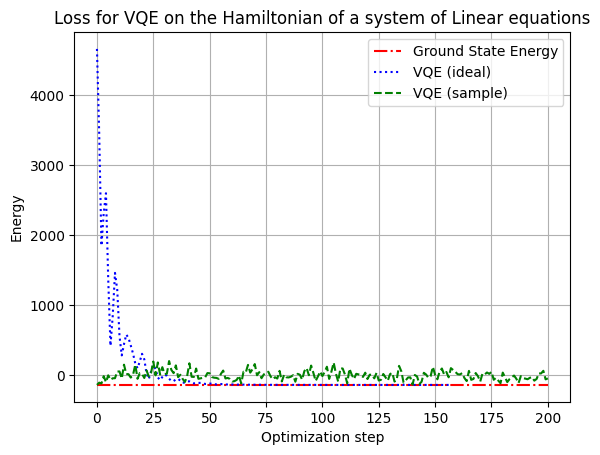

In [5]:
min_eigenvalue = hamiltonian_until.min_eigenvalue

print("abs error ideal = ", abs(min_eigenvalue - ideal_cost_history[-1]))
print("abs error sample = ", abs(min_eigenvalue - sample_cost_history[-1]))

length = max(len(ideal_cost_history), len(sample_cost_history))

# 绘图比较
plt.grid()
plt.plot(range(length), min_eigenvalue * np.ones(length), color='r', linestyle='-.', label='Ground State Energy')
plt.plot(range(len(ideal_cost_history)), ideal_cost_history, color='b', linestyle=':', label='VQE (ideal)')
plt.plot(range(len(sample_cost_history)), sample_cost_history, color='g', linestyle='--', label='VQE (sample)')

plt.xlabel('Optimization step')
plt.ylabel('Energy')

plt.legend()
plt.title(f'Loss for VQE on the Hamiltonian of a system of Linear equations')
plt.show()

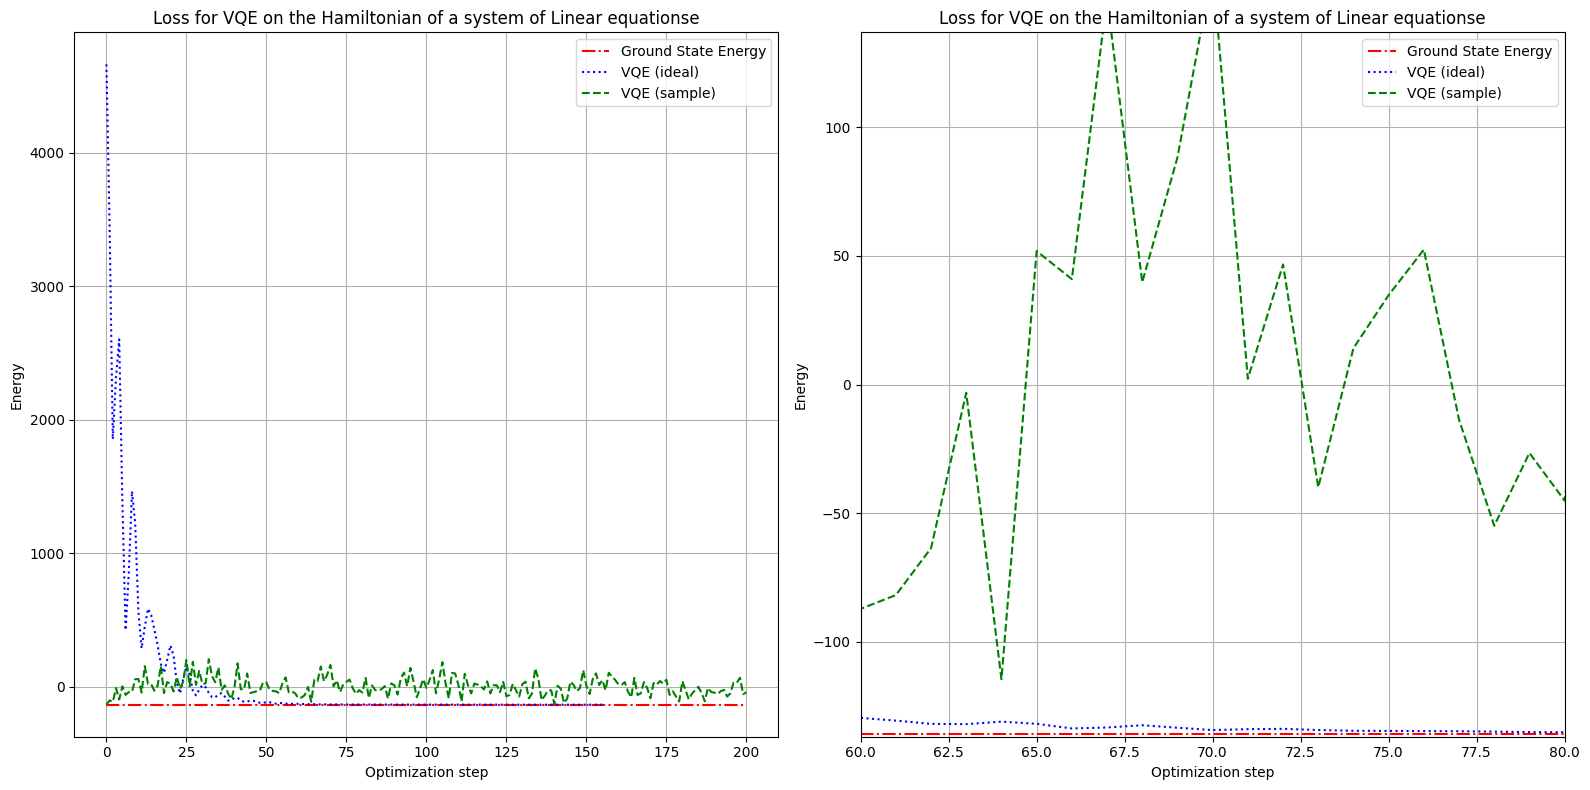

In [6]:
# 创建子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 第一个子图：完整图
ax1.grid()
ax1.plot(range(length), min_eigenvalue * np.ones(length), color='r', linestyle='-.', label='Ground State Energy')
ax1.plot(range(len(ideal_cost_history)), ideal_cost_history, color='b', linestyle=':', label='VQE (ideal)')
ax1.plot(range(len(sample_cost_history)), sample_cost_history, color='g', linestyle='--', label='VQE (sample)')

ax1.set_xlabel('Optimization step')
ax1.set_ylabel('Energy')
ax1.legend()
ax1.set_title('Loss for VQE on the Hamiltonian of a system of Linear equationse')

# 第二章子图，则是截断横纵坐标，展示细节
ax2.grid()
ax2.plot(range(length), min_eigenvalue * np.ones(length), color='r', linestyle='-.', label='Ground State Energy')
ax2.plot(range(len(ideal_cost_history)), ideal_cost_history, color='b', linestyle=':', label='VQE (ideal)')
ax2.plot(range(len(sample_cost_history)), sample_cost_history, color='g', linestyle='--', label='VQE (sample)')

# 手动设置纵坐标范围
ax2.set_xlim(60, 80)
ax2.set_ylim(-137, 137)
ax2.set_xlabel('Optimization step')
ax2.set_ylabel('Energy')
ax2.legend()
ax2.set_title('Loss for VQE on the Hamiltonian of a system of Linear equationse')

plt.tight_layout()
plt.show()



In [7]:
# 正确答案的量子态
min_eigenvector = hamiltonian_until.min_eigenvector

# 变分电路学到的量子态
# 构造运行节点
qnode_state = qml.QNode(VQE_until.variational_circuit_state, dev_ideal)
circuit_state = qnode_state(ideal_params_history[-1], deep_layer)

# 参看正确答案对应序号的概率
print(np.argmax(circuit_state))
print(circuit_state[940]**2)

940
(0.9999999804460044+0j)


In [8]:
# 测量模式下，测量概率
qnode_prob = qml.QNode(VQE_until.variational_circuit_prob, dev_sample)
sample_prob = qnode_prob(sample_params_history[-1], deep_layer)

print(np.argmax(circuit_state))
print(sample_prob[940])

940
0.9970703125
